# Time Series Forecast on Monthly Sales for Retail and Food Service - RNN
## Dan Olaleye

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

## Starter Code

In [0]:
# To use google colab's GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Personal Projects/Time Series/Monthly Sales for Retail and Food Service/RSCCASN.csv'

df = pd.read_csv(path, index_col='DATE', parse_dates=True)

In [0]:
df.head(5)

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [0]:
df.columns = ['Sales']

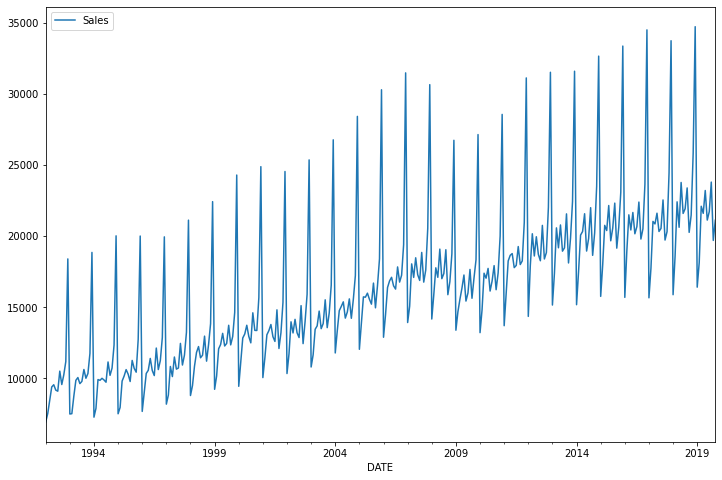

In [0]:
df.plot(figsize=(12,8))

In [0]:
## Train Test Split

In [0]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [0]:
n_months = 18

test_ind = len(df) - n_months
test_ind

316

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [0]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [0]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [0]:
from sklearn.preprocessing import MinMaxScaler 

In [0]:
scaler = MinMaxScaler()

In [0]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
#Redefine the variable to get the lenght of 12 months at a time to predict the next month

length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [0]:
X,y = generator[0]


## The Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [0]:
n_features = 1

#Define Model

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(lenght, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Early Stopping and Validation Generation**

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [0]:
model.fit_generator(generator, epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0264 - val_loss: 0.0140
Epoch 2/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0182 - val_loss: 0.0028
Epoch 3/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0109 - val_loss: 9.4716e-04
Epoch 4/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 5/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0029 - val_loss: 0.0038


In [0]:
losses = pd.DataFrame(model.history.history)

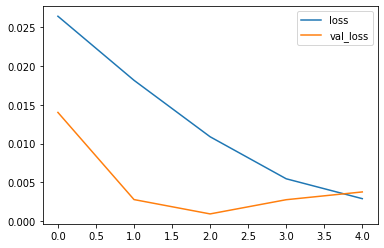

In [0]:
losses.plot()

## Test Prediction

In [0]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Comparisons

In [0]:
true_predictions = scaler.inverse_transform(test_predictions)

In [0]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22625.372655
2018-06-01,21589,21773.914962
2018-07-01,21919,22006.618297
2018-08-01,23381,23584.839461
2018-09-01,20260,21600.887611
2018-10-01,21473,22131.084315
2018-11-01,25831,25564.772307
2018-12-01,34706,35030.988178
2019-01-01,16410,18811.686772


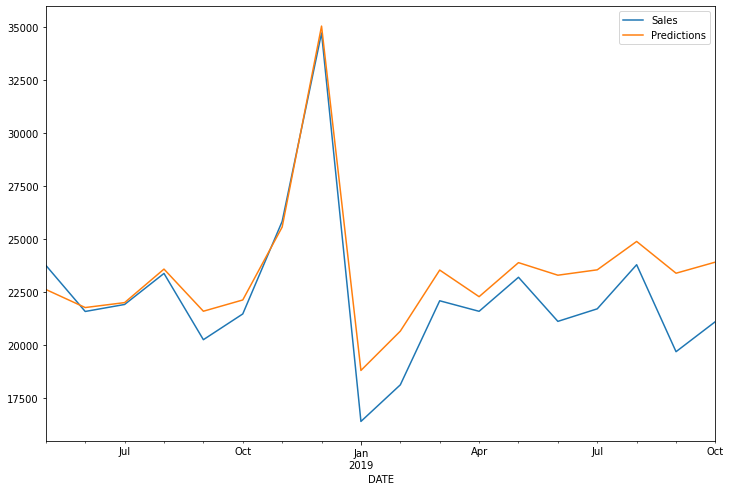

In [0]:
test.plot(figsize=(12,8))

## Retraining and Forcasting

In [0]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [0]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [0]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator, epochs=5)

Epoch 1/5
322/322 [==============================] - 6s 18ms/step - loss: 0.0261
Epoch 2/5
322/322 [==============================] - 6s 18ms/step - loss: 0.0169
Epoch 3/5
322/322 [==============================] - 6s 18ms/step - loss: 0.0096
Epoch 4/5
322/322 [==============================] - 6s 18ms/step - loss: 0.0051
Epoch 5/5
322/322 [==============================] - 6s 18ms/step - loss: 0.0031


In [0]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
forecast = scaler.inverse_transform(forecast)

## Creating new timestamp index with pandas.

In [0]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [0]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

In [0]:
forecast_df

,Forecast
2019-11-01,25632.640624
2019-12-01,34731.838283
2020-01-01,17775.998424
2020-02-01,18915.033314
2020-03-01,21881.044097
2020-04-01,21459.536191
2020-05-01,22783.927978
2020-06-01,21053.303129
2020-07-01,21533.375554
2020-08-01,23298.140600


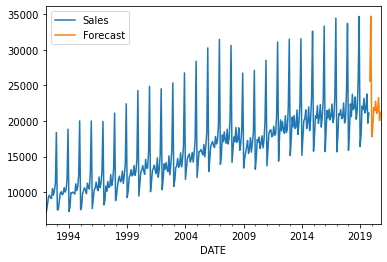

In [0]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

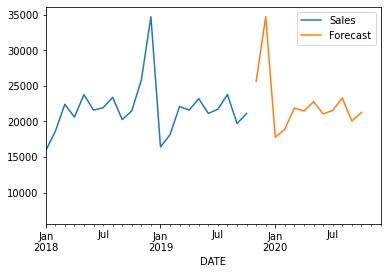

In [0]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')